## make proj-pres_grid-mode_dataset

Prepare static fields required for computing and projecting pressure in eNATL60. This uses pre-computed grid fields (at rest and associated with mean ssh) and vertical modes. Output is stored in a zarr archive, with chunking aligned with pressure projection requirements: x=-1, y=100, z=10.

TODO: adapt it to use mesh_mask_eNATL60_3.6.nc instead of eNATL60_rest_grid.zarr. Otherwise untar the latter zarr archive from the STOREDIR.

In [1]:
#from glob import glob
from pathlib import Path
import os, time
import datetime

import xarray as xr

In [2]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(n_workers=8) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42654 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [3]:
### define paths
scratch = Path(os.getenv("SCRATCHDIR"))
workdir = Path("/work/CT1/ige2071/nlahaye")
worksha = (workdir/"../SHARED").resolve()

dico_path = {"grid_rest": workdir/"eNATL60_rest_grid.zarr",
            "grid_mean": workdir/"eNATL60_mean_grid_z.zarr",
            "vmods": worksha/"vmodes/vmodes_10.zarr", 
            "pres": scratch/"global_mean_pres.zarr"
           }

### define chunking
chunks = {"z":10, "y":100, "x":-1, "mode":1}
    
# replicate chunks in terms of target dimensions
chunks_tg = {di:chunks[di[0]] for di in ["z_c", "z_l"]}
for di in ("x", "y"):
    chunks_tg.update({di+"_"+su:chunks[di] for su in ["c","r"]})
    
def rechunk(ds, chks=chunks_tg):
    return ds.chunk({k:chks[k] for k in ds.dims if k in chks})

In [4]:
dico_vars = {"grid_rest": {"e3w":{"rename":"e3w_0", 
                                 "attrs": {"description": "3D vertical grid metrics at rest, w-points"}
                                 }, 
                           "tmask":{},
                           "llon_cc":{},
                           "llat_cc":{}
                          },
            "grid_mean": {"depth_c_3d":{"rename":"depth_c_m", 
                                        "attrs":{"description": "mean 3D z grid at T points (algebraic depth)"}
                                       },
                          "hbot":{}, 
                          "sossheig":{"attrs":{"description": "mean SSH"}},
                          "e3t":{"rename":"e3t_m", 
                                "attrs":{"description":"3D vertical grid metrics, annual mean, T-points"}
                                }
                         },
             "vmods": {"phi":{}, "norm":{}},
             "pres": {"pres":{"rename":"pres_m", "attrs":{"description":"annual mean pressure anomaly"}}
                     }
            }

to_vars = ["sossheig", "phi", "pres_m", "e3w_0", "e3t_m", "depth_c_m"]

out_file = scratch/"eNATL60_grid_vmodes_proj_pres.zarr"


In [5]:
%%time
ds = xr.Dataset()
for key,varnames in dico_vars.items():
    print("now opening", key)
    if dico_path[key].suffix == ".zarr":
        sds = rechunk(xr.open_zarr(dico_path[key]))
    else:
        sds = xr.open_dataset(dico_path[key], chunks=chunks_tg) # will likely fail because of chunks no in dims
    vnams = [v for v in varnames.keys()]
    sds = sds.get(vnams)
    sds = sds.reset_coords([c for c in sds.coords if c not in vnams and c not in sds.dims])
    for k,v in varnames.items():
        if "rename" in v:
            sds = sds.rename({k:v["rename"]})
            k = v["rename"]
        if "attrs" in v:
            sds[k].attrs.update(v["attrs"])
        if len(sds[k].dims) >=3 and sds[k].dtype == "float64":
            sds[k] = sds[k].astype("float32")
    ds = ds.merge(sds)
    
### separte variables and coordinates
ds = ds.set_coords([c for c in ds.data_vars if c not in to_vars])
for k in ds.coords:
    ds[k].encoding.pop("chunks", None)
for k in ds.data_vars:
    ds[k].encoding.pop("chunks", None)
   
### add attributes
ds.attrs["description"] = "Dataset containing various static fields for projecting pressure on vertical modes in eNATL60"
ds.attrs["date created"] = datetime.date.today().isoformat()
ds.attrs["generated by"] = "N. Lahaye (noe.lahaye@inria.fr)"
ds.attrs["generating script"] = 'jupyter notebook "make_projpres_gridmode_dataset.ipynb"'

ds

now opening grid_rest
now opening grid_mean
now opening vmods
now opening pres
CPU times: user 10.6 s, sys: 1.76 s, total: 12.4 s
Wall time: 17.4 s


<xarray.Dataset>
Dimensions:    (mode: 11, x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
    tmask      (z_c, y_c, x_c) int8 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(100, 8354), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
    hbot       (y_c, x_c) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    depth_c    (z_c) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    norm       (y_c, x_c, mode) float32 dask.array<chunksize=(100, 8354, 1), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(100, 8354), meta=np.ndarray>
Data variables:
    e3w_0      (z_l, y_c, x_c) float32 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    depth_c_m  (z_c, y_c, x_c) float32 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    sossheig   (y_c, x_c) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    e3t_m      (z_c, y_c, x_c) float32 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    phi        (y_c, x_c, z_c, mode) float32 dask.array<chunksize=(100, 8354, 10, 1), meta=np.ndarray>
    pres_m     (z_c, y_c, x_c) float32 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>

In [31]:
###time
# simplify norm OR NOT
abs(ds.norm.where(ds.tmaskutil).std("mode")).max().values

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


array(0.00055899, dtype=float32)

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


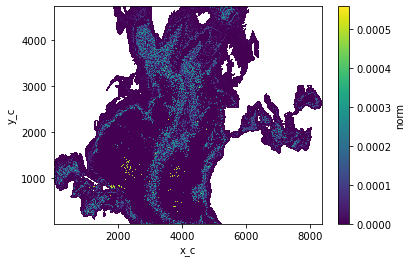

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt

ds.norm.where(ds.tmaskutil).std("mode").plot()

In [61]:
%%time
ds.to_zarr(out_file, mode="w", compute=False, consolidated=True)

CPU times: user 12.1 s, sys: 617 ms, total: 12.7 s
Wall time: 14.4 s


Delayed('_finalize_store-d1b2d819-f7e7-411a-8a9a-9b53e92755b3')

In [62]:
%%time
### write coordinates
ds.get([c for c in ds.coords]).to_zarr(out_file, mode="a", compute=True)

CPU times: user 32 s, sys: 1.71 s, total: 33.7 s
Wall time: 34.1 s


In [7]:
ds.get(["sossheig"]).isel({})

<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729)
Coordinates:
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(100, 8354), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
    hbot       (y_c, x_c) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(100, 8354), meta=np.ndarray>
Data variables:
    sossheig   (y_c, x_c) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
Attributes:
    description:        Dataset containing various static fields for projecti...
    date created:       2021-06-18
    generated by:       N. Lahaye (noe.lahaye@inria.fr)
    generating script:  jupyter notebook "make_projpres_gridmode_dataset.ipynb"

In [14]:
%%time
### write variables
deja_fait = ["e3w_0", "depth_c_m", "sossheig", "e3t_m"]
for v in ds.data_vars:
    if v in deja_fait:
        print("skipping", v)
        continue
    tmes = time.time()
    if len(ds[v].dims)<4:
        ds.get([v]).reset_coords(drop=True).to_zarr(out_file, mode="a", compute=True)
    else:
        print("starting loop on mode:", end=" ")
        if "mode" not in ds[v].dims:
            raise ValueError("did not found dimension mode")
        region = {k:slice(0,None) for k in ds[v].dims}
        for imod in range(ds.mode.size):
            region["mode"] = slice(imod,imod+1)
            ds.get([v]).isel(mode=region["mode"]).reset_coords(drop=True).to_zarr(out_file, 
                                                                                  mode="a", 
                                                                                  compute=True,
                                                                                 region=region)
            print(imod, end=", ")
    print("{} took {:.1f} s".format(v, time.time()-tmes))

skipping e3w_0
skipping depth_c_m
skipping sossheig
skipping e3t_m
starting loop on mode: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, phi took 409.1 s
pres_m took 30.0 s
CPU times: user 3min 49s, sys: 17.5 s, total: 4min 6s
Wall time: 7min 19s


In [15]:
from numpy import sin, cos as co

In [19]:
cos(3.14)

NameError: name 'cos' is not defined